In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
# in terminal, do pip install blis to install the below package for fast matrix multiplication
from blis.py import gemm

## Some comments on matrix multiplication...

You can use the BLIS linear algebra library to speed up matrix multiplication for large, multidimensional matrices.

However, make sure to check that the method that you're using is actually appropriate for your problem!

It turns out that BLIS is slower than numpy for small matrix size...

Of course, if you REALLY want speed, use C++... right?



In [2]:
def blis_gemm_2d(X, W):
    """
    Fast matrix multiplication using blis.py
    -------------------------------------------
    Inputs:
    X: matrix shape (a,b)
    W: matrix shape (b,c)
    ------------------------------------------
    Output:
    X /dot W: matrix shape  (a,c)
    """
    C = np.zeros(W.shape)
    gemm(X, W, out=C)
    
    return C

In [3]:
def blis_gemm_3d(X, W):
    """
    Fast matrix multiplication using blis.py
    -------------------------------------------
    Inputs:
    X: matrix shape (a,b,c)
    W: matrix shape (c,d)
    ------------------------------------------
    Output:
    X /dot W: matrix shape  (a,b,d)
    """
    contain=[]
    for i in range(X.shape[0]):
        y=gemm(X[i,:,:], W, trans1=False, trans2=False)
        contain.append(y)
    contain=np.array(contain)
    return(contain)

In [4]:
N = 500
X = np.random.rand(N,N)
Y = np.random.rand(N,N,N)


In [5]:
# 2D: note that numpy is faster!

time1 = time.time()
np.dot(X,X)
time2 = time.time()
print(f'numpy took {time2-time1} s')

time1 = time.time()
blis_gemm_2d(X,X)
time2 = time.time()
print(f'BLIS took {time2-time1} s')

numpy took 0.019416332244873047 s
BLIS took 0.005707740783691406 s


In [6]:
# 3D: BLIS is faster!

time1 = time.time()
np.dot(Y,X)
time2 = time.time()
print(f'numpy took {time2-time1} s')

time1 = time.time()
blis_gemm_3d(Y,X)
time2 = time.time()
print(f'BLIS took {time2-time1} s')

numpy took 52.68464422225952 s
BLIS took 3.315354824066162 s


### Implementation matters!

Below I implement the 2D matrix multiplication algorithm naiively in both cython and pure python.

Note that the naiive implementations are much slower than numpy dot! But naiive cython is much, much faster than naiive pure python.

Lesson: don't reinvent the wheel unless you have to! Use already written algorithms like np.dot and BLIS when you can, it's likely that these are faster than anything you can come up with.

However, if you need speed and have to do something novel, use C++. If your code must be in python, use cython to put C++ code in your python scripts. 

In [7]:
import c_mult_cython
#pass in terminal: python setup.py build_ext --inplace
# make sure you download c_mult_cython.pyx and setup.py

In [8]:
def matmult(A, B):
    C = np.zeros([A.shape[0], B.shape[1]])
    for i in range(A.shape[0]):
        for j in range(B.shape[1]):
            for k in range(A.shape[1]):
                C[i,j] += A[i,k]*B[k,j]
    return C

In [9]:
N = 400
X = np.random.rand(N,N)
Y = np.random.rand(N,N,N)

time1 = time.time()
c_mult_cython.c_mult_cython_2d(X,X)
time2 = time.time()
print(f'naiive cython took {time2-time1} s')

time1 = time.time()
np.dot(X,X)
time2 = time.time()
print(f'numpy dot took {time2-time1} s')

time1 = time.time()
matmult(X,X)
time2 = time.time()
print(f'naiive numpy took {time2-time1} s')

time1 = time.time()
blis_gemm_2d(X,X)
time2 = time.time()
print(f'BLIS took {time2-time1} s')

naiive cython took 0.05609846115112305 s
numpy dot took 0.0007586479187011719 s
naiive numpy took 21.088424682617188 s
BLIS took 0.002514362335205078 s


## Radioactive decay chain: loop implementation

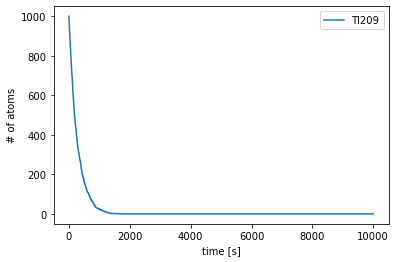

In [12]:
NTl = 1000
# calculate half lives of elements in seconds
hl = 3.053*60 #s

# time step is 1 second
dt = 1 #s

# initial numbers of atoms
#NTl = 1000
NPb = 0
# calculate half lives of elements in seconds
hl = 3.053*60 #s

# calculate probability that each element will decay in 1 time step
p_dt = 1 - 2**(-dt/hl)

NTl_list = []
NPb_list = []

t = np.arange(0,1e4,dt)
for ti in t:
    NTl_list.append(NTl)
    NPb_list.append(NPb)
    # start at the bottom of the decay chain to avoid double counting atoms
    for i in range(NTl): # calculate how many Pb209 decay into Bi209
        if np.random.random()<p_dt:
            NTl-=1
            NPb+=1

plt.plot(t,NTl_list,label='Tl209', zorder = -1)
#plt.plot(t,NPb_list,label='Pb209')
plt.legend()
plt.xlabel('time [s]')
plt.ylabel('# of atoms')
plt.show()

### Dealing with branching: Start at the bottom of the decay chain and work upward to avoid double counting!

Pseudocode:

for each Bi213 atom: # calculate how many Bi213 decay into Pb209 AND Tl209

    if random < p_dt_Bi:
    
        subtract 1 from Bi213
        
        if random < 0.9791: # calculate how many Bi213 decay into Pb209
        
            add 1 to Pb209
            
        else: # calculate how many Bi213 decay into Tl209
        
            add 1 to Tl209
                

### On chalkboard: transformation method

### On chalkboard: Bateman equation